In [152]:
import pandas as pd # needs pyarrow > 0.13 to load data below
import numpy as np

# Notes on running this notebook

Assumes requirements in `MungingWithPandas_env.yaml`. 

If you have conda, these requirements can be loaded with

`conda env create -f MungingtWithPandas_env.yaml`

then:

`conda activate MungingWithPandas`

To exit from virtual environment, back to base, just `conda deactivate`


# Data munging with pandas

Pandas did more than extend `np.arrays` to `pd.Series` and `pd.DataFrames`, but also organized a system of methods based transformations and joins that can help us move our data from raw bits to useful features. 

The process of chipping, churning, spliting, stirring, and mixing data is known as **data munging**.


## Load data

Let's load in some data from the Violence Early Warning Project, available [here](https://views.pcr.uu.se/download/datasets/cm_africa_imp_0.parquet)

The data is in `parquet` format, more information [here](https://en.wikipedia.org/wiki/Apache_Parquet).

Apache `parquet` stores information in columns, as opposed to csv files where information is read and written in rows. These are trade-offs to both.

We can use `pd.read_parquet` to read in the data more information can be had at `?pd.read_parquet`

There are many different build in read and write functions in pandas, including a very nice `read_csv` implementation.

In [4]:
cm_df = pd.read_parquet("cm_africa_imp_0.parquet")

`pd.read_parquet` reads in file from disk or from the web into memory. The information in the file is arranged into a `pd.DataFrame` object for us. 

A `pd.DataFrame` is comprised of `pd.Series` which are vectors of data in columns.

You can think about DataFrames as spreadsheets in memory.


## Peaking at the Data

Data can be messy, and this is no exception. Lets check out the dimensions, rows and columns, using the `pd.DataFrame.shape` attribute. This is inhereted from `numpy`.

In [5]:
cm_df.shape

(33048, 3725)

This is a country month dataset. It holds information on different forms of conflict and features that might be helpful in predicting future conflict.

Lets take a look at the first few rows using the method `.head()`

In [6]:
cm_df.head()

Not that helpful given there are so many column. 


## Subsetting DataFrame

We will use `.loc` to subset the rows and the columns. The data uses `multi-indexing` (see the `month_id` column looks weird. The rows are uniquely labeled by the combination of `month_id` and `country_id`. (Note: see the SciPyStack keynote file for more on how to index and access DataFrames)

This is a way of efficientfly grouping obervations.

`.loc` uses names (even if the name is an int), and `.iloc` uses counts/integers.

### A side note on MultiIndexing

This data uses MultiIndexing for rows. This is a way or organizing hierarchical data.

The contours of `MultiIndexing` are covered in the pandas docs [here](https://pandas.pydata.org/docs/user_guide/advanced.html#advanced). 

We can grab rows using a tuple `(month_id_slice, country_id_slice)` for the row names, and then a list for the columns we want to keep.

Lets get all of the countries, for the first month to test things out; while only grabbing a few columns.

Note that `slice(None)` means give me everything.

In [27]:
cm_df.loc[(1, slice(None)), ["ged_best_ns", "month", "year", "country_name"]]

ged_best_ns  month  year              country_name
month_id country_id                                                    
1        40                  NaN      1  1980                Cape Verde
         41                  NaN      1  1980             Cote d'Ivoire
         42                  NaN      1  1980                     Ghana
         43                  NaN      1  1980                   Liberia
         47                  NaN      1  1980              Burkina Faso
         48                  NaN      1  1980                    Guinea
         49                  NaN      1  1980             Guinea-Bissau
         50                  NaN      1  1980                      Mali
         52                  NaN      1  1980                   Senegal
         53                  NaN      1  1980              Sierra Leone
         54                  NaN      1  1980                The Gambia
         55                  NaN      1  1980                  Djibouti
         56                  NaN      1  1980                   Eritrea
         57                  NaN      1  1980                  Ethiopia
         67                  NaN      1  1980                   Algeria
         69                  NaN      1  1980                  Cameroon
         70                  NaN      1  1980  Central African Republic
         73                  NaN      1  1980                   Tunisia
         74                  NaN      1  1980                     Benin
         76                  NaN      1  1980         Equatorial Guinea
         78                  NaN      1  1980                     Niger
         79                  NaN      1  1980                   Nigeria
         80                  NaN      1  1980     Sao Tome and Principe
         81                  NaN      1  1980                      Togo
         120                 NaN      1  1980                   Somalia
         154                 NaN      1  1980                  Botswana
         155                 NaN      1  1980                   Burundi
         156                 NaN      1  1980                    Rwanda
         157                 NaN      1  1980                    Zambia
         158                 NaN      1  1980                  Zimbabwe
         159                 NaN      1  1980                   Comoros
         160                 NaN      1  1980                   Lesotho
         161                 NaN      1  1980                    Malawi
         162                 NaN      1  1980                Mozambique
         163                 NaN      1  1980              South Africa
         164                 NaN      1  1980                 Swaziland
         165                 NaN      1  1980                    Angola
         166                 NaN      1  1980                     Congo
         167                 NaN      1  1980                Congo, DRC
         169                 NaN      1  1980                     Gabon
         170                 NaN      1  1980                   Namibia
         172                 NaN      1  1980                Madagascar
         173                 NaN      1  1980                 Mauritius
         174                 NaN      1  1980                Seychelles
         213                 NaN      1  1980                     Libya
         214                 NaN      1  1980                      Chad
         222                 NaN      1  1980                     Egypt
         235                 NaN      1  1980                    Uganda
         237                 NaN      1  1980                     Kenya
         242                 NaN      1  1980                  Tanzania
         243                 NaN      1  1980                   Morocco
         244                 NaN      1  1980                Mauritania
         245                 NaN      1  1980                     Sudan
         246                 NaN      1  1980               S

### Subsetting with MultiIndexes

We can grab multiple months too, while subsetting countries using slices, that grab consequetive values; and lists where you can specify discrete items to grab.

Lets grab DRC (167) and Somalia (120) starting in January 1989 (109) and stopping in Dec 2000 (252).

We use:

- `slice(109, 252)`, which is a slice object, to get the dates as the first part of the tuple for the MultiIndex (val1 below)
- `[120, 167]` , which is just a list, to get the 2 countries (val2 below).

The general syntax is `pd.DataFrame.loc[(va1, va12), [columns to keep]]`

In [363]:
subset_df = cm_df.loc[(slice(109, 252), [120, 167]), ["ged_best_ns", "month", "year", "country_name"]]

In [364]:
subset_df

ged_best_ns  month  year country_name
month_id country_id                                       
109      120                 0.0      1  1989      Somalia
         167                 0.0      1  1989   Congo, DRC
110      120                 0.0      2  1989      Somalia
         167                 0.0      2  1989   Congo, DRC
111      120                 0.0      3  1989      Somalia
...                          ...    ...   ...          ...
250      167                76.0     10  2000   Congo, DRC
251      120                 0.0     11  2000      Somalia
         167                60.0     11  2000   Congo, DRC
252      120                 0.0     12  2000      Somalia
         167                16.0     12  2000   Congo, DRC

[288 rows x 4 columns]

## Finding a row index value for a given variable value

It is useful to see how we can find the indices for given values. 

First, for a given row, either using `.loc` or `.iloc` we can use the `.index` attribute to return the index (here a MultiIndex) for the row. 

Note that even though I am providing `.iloc` with just one integer row number (a count not a name because this is `.iloc`), I use a list around it. This ensures I get a `pd.DataFrame` back from `.iloc` instead of the row as a `pd.Series` . A `pd.DataFrame` has an `.index` attribute, but a `pd.Series` object does not (unless you make one).

In [365]:
subset_df.iloc[[0]].index

MultiIndex([(109, 120)],
           names=['month_id', 'country_id'])

If we want to find the `country_id` index for `Congo, DRC` we can use the value of the `country_names` column to filter on, returning only those that equal `Congo, DRC`. Then we can pick the first value out of that to return the index.

Lets do this in steps.

First, only view the rows where `"country_name"=="Congo, DRC"`

We do this by selecting by boolean values.

In [74]:
subset_df[subset_df['country_name']=="Congo, DRC"]

,,ged_best_ns,month,year,country_name
month_id,country_id,,,,
109,167,0.0,1,1989,"Congo, DRC"
110,167,0.0,2,1989,"Congo, DRC"
111,167,0.0,3,1989,"Congo, DRC"
112,167,0.0,4,1989,"Congo, DRC"
113,167,0.0,5,1989,"Congo, DRC"
...,...,...,...,...,...
248,167,0.0,8,2000,"Congo, DRC"
249,167,63.0,9,2000,"Congo, DRC"
250,167,76.0,10,2000,"Congo, DRC"


We can see that the `subset_df['country_name']=="Congo, DRC"` portion returns a pd.Series of boolean values (and each rows unique index)

In [75]:
subset_df['country_name']=="Congo, DRC"

month_id  country_id
109       120           False
          167            True
110       120           False
          167            True
111       120           False
                        ...  
250       167            True
251       120           False
          167            True
252       120           False
          167            True
Name: country_name, Length: 288, dtype: bool

In [76]:
type(subset_df['country_name']=="Congo, DRC")

pandas.core.series.Series

Next we grab the first row using `.iloc[[0]]`

In [77]:
subset_df[subset_df['country_name']=="Congo, DRC"].iloc[[0]]

,,ged_best_ns,month,year,country_name
month_id,country_id,,,,
109,167,0.0,1,1989,"Congo, DRC"


This is still a pd.DataFrame so, next, we can grab the index 

In [87]:
subset_df[subset_df['country_name']=="Congo, DRC"].iloc[[0]].index

MultiIndex([(109, 167)],
           names=['month_id', 'country_id'])

We can even go a little farther. In many places pandas wraps numpy, and you can grab the numpy object with the values attribute.

In [88]:
subset_df[subset_df['country_name']=="Congo, DRC"].iloc[[0]].index.values

array([(109, 167)], dtype=object)

This is a numpy array, that is holding a tuple. We can grab the tuple and then the second (first in Python counting) item.

In [89]:
subset_df[subset_df['country_name']=="Congo, DRC"].iloc[[0]].index.values[0][1]

167

While this was the long way around (we could have just glanced) it tells us a lot about the inner-workings of pandas objects.

## Creating a lookup table

In production, when you have a variable that is, in essence acting as an alias for an index, as `country_name` is for `countri_id`, it is useful to create a look-up table, without redundant values to go from one to the other.

The `.drop_duplicates` method is a way of accomplishing this.

Let's use it to create a separate table that will allow us to look up `country_id` with a `country_name`. 

In [121]:
temp = subset_df.drop_duplicates(subset='country_name')[["country_name"]]
temp

country_name
month_id country_id             
109      120             Somalia
         167          Congo, DRC

Note that we got the first value, you cant get the last by passing the argument `keep="last"`.

Now we will just grab 

- the second item of the MultiIndex that represents `country_id`
    - we could do this with a list comprehsion like so:
        - `[x[1] for x in temp.index.values]`
    - however, it is more readable to use the name of the index not the position in the tuple, so I use:
        - `temp.index.to_frame()["country_id"].values`
- the `country_name` column values as the index

and rearrange them so that `country_name` is the index and `country_id` is a Series in a DataFrame

In [258]:
lookup_country_names = pd.DataFrame({"country_id": temp.index.to_frame()["country_id"].values}, 
                                    index=temp["country_name"].values)
lookup_country_names

,country_id
Somalia,120
"Congo, DRC",167


Now we can look up ids if we need them...

In [259]:
print(lookup_country_names.loc["Somalia"])
# or
lookup_country_names.loc["Somalia"].values[0]

country_id    120
Name: Somalia, dtype: int64


120

We can wrap that into a function and do it for the full dataset

In [254]:
def make_country_name_lookup(df: pd.DataFrame) -> pd.DataFrame:
    """Create a look up table from the cm_df data frame"""
    temp = df.drop_duplicates(subset='country_name')[["country_name"]]
    return pd.DataFrame({"country_id": temp.index.to_frame()["country_id"].values}, index=temp["country_name"].values)

In [255]:
make_country_name_lookup(cm_df).head(n=25)

,country_id
Cape Verde,40
Cote d'Ivoire,41
Ghana,42
Liberia,43
Burkina Faso,47
Guinea,48
Guinea-Bissau,49
Mali,50
Senegal,52
Sierra Leone,53


For completeness here is a function to grab the int value from the lookup table

You can also see in these functions that we can use np and pd objects to type hint (if type hinting is not clicking, lecture on that topic).

In [150]:
def get_country_id(lookup_df: pd.DataFrame, name: str) -> np.int64:
    return lookup_df.loc[name].values[0]

In [151]:
lu_names = make_country_name_lookup(cm_df)
get_country_id(lu_names, "Togo")

81

## Split-Apply-Combine

We often want to remake our data in different ways. 

For example, in the `cm_df` we might want to aggregate non-state fatalities by month over the countries or by country over the months.

Perhaps we might want to look for seasonality, and aggregate by month of the year (as opposed to a counter of the unique months).

Alternatively, we might want to count the number of years since the last non-state fatality.

All of these operations, and so many more, fit in the split-apply-combine framework.

Lets dissaggregate that:

- split -- we often want to treat our data as if it is actually many different orthogonal sets of data, where we chunk the data into parts (eg by month or by country). Each chuck has a unique key that refers to it (like a MultiIndex).

- apply -- to each chunk of the data, we often want to apply some transformation (eg sum or count something)

- combine -- after apply a function to each chunk, we want to recombine everything together back into one DataFrame/object.

Each of these steps is implemented in different coding languages and even in different packages within coding languages, and pandas is no different.

### .groupby

Pandas uses `.groupby` method on `pd.DataFrames` to organize a virtual split, that is ready for an apply. This is taken from the SQL `GROUP BY` command.

`.groupby` also glues everything back together.

When we do something of the form `pd.DataFrame.groupby(column_name)`, this gives us an object that can act like separate data frames for each unique value in `column_name`.

Lets try it out first with our smaller `subset_df`

In [154]:
subset_df.groupby("country_name")

So far we just have a `groupby` object. That is becaues pandas is doing a lot of work for us under hood. 

### built-in apply methods

To take advantage of that lets get the sum of the non-state fatalities for each of our countries in the `subset_df`, which is only a small number of years.

We will use a built-in method for `pd.DataFrames`, the `.sum` method.

What pandas will do is that when you call `.sum` on a `.groupby` object it will ... you guessed it, apply the sum function to each of the chunks defined by `.groupby`.

It will then combine things back together in a pandas object for you.

Lets try it out.

After grouping we will select the column to sum over using indexing (the name of the column in this case), and then call sum. 

In [160]:
subset_df.groupby("country_name")["ged_best_ns"].sum()

country_name
Congo, DRC    7143.0
Somalia       6525.0
Name: ged_best_ns, dtype: float64

A few things to notice here.

1. We get a nice left to write, readable statement about what is happening. This happens because we are chaining together methds that fit together like puzzle pieces. You can read it as, take your data frame, group it by country name, select the column `"ged_best_ns"` in each group, and then sum for those groups.

2. The statement returned a pd.Series object. What is returned from method that is being applied will depend on the method. See the `.describe` example below as that produces a DataFrame.

3. It would have taken several steps to do this imperatively. This is a good example of how Python mixes functional and object oriented syntax to get work done.

Lets group by country and sum for the whole `cm_data` and then sort then by most fatalities to least, and for good measure, lets only look at the top 10.

Again, we have a nice left to right structure. Note that we use `.sort_values` without a column name because `.sum` on a `.groupby` object gives us a `pd.Series`

In [167]:
cm_df.groupby("country_name")["ged_best_ns"].sum().sort_values(ascending=False).head(n=10)

country_name
Nigeria                     23378.0
Sudan                       21653.0
Congo, DRC                  16858.0
Somalia                     11696.0
Ethiopia                     7758.0
Libya                        4830.0
South Sudan                  4467.0
Kenya                        4382.0
South Africa                 4319.0
Central African Republic     3747.0
Name: ged_best_ns, dtype: float64

There is a great deal of context that could be added. For example, population, missing data (new countries), etc; but this gives a look at what pandas can do for re-arranging data.

Lets see if we can use the `.describe` methods to help us understand the data better. This ignores missing values (`NaN`) values.

In [174]:
cm_df.groupby("country_name")[["year", "ged_best_ns"]].describe().head(n=15)

year                                             \
                          count    mean        std     min     25%     50%   
country_name                                                                 
Algeria                   612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Angola                    612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Benin                     612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Botswana                  612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Burkina Faso              612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Burundi                   612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Cameroon                  612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Cape Verde                612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Central African Republic  612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Chad                      612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Comoros                   612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Congo                     612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Congo, DRC                612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Cote d'Ivoire             612.0  2005.0  14.731642  1980.0  1992.0  2005.0   
Djibouti                  612.0  2005.0  14.731642  1980.0  1992.0  2005.0   

                                         ged_best_ns                         \
                             75%     max       count       mean         std   
country_name                                                                  
Algeria                   2018.0  2030.0       382.0   1.280105   13.731492   
Angola                    2018.0  2030.0       382.0   0.000000    0.000000   
Benin                     2018.0  2030.0       382.0   0.000000    0.000000   
Botswana                  2018.0  2030.0       382.0   0.000000    0.000000   
Burkina Faso              2018.0  2030.0       382.0   0.468586    5.544647   
Burundi                   2018.0  2030.0       382.0   1.212042   12.419169   
Cameroon                  2018.0  2030.0       382.0   0.761780    4.655401   
Cape Verde                2018.0  2030.0       382.0   0.000000    0.000000   
Central African Republic  2018.0  2030.0       382.0   9.808901   33.319146   
Chad                      2018.0  2030.0       382.0   1.395288   10.371740   
Comoros                   2018.0  2030.0       382.0   0.104712    2.046578   
Congo                     2018.0  2030.0       382.0   0.000000    0.000000   
Congo, DRC                2018.0  2030.0       382.0  44.130890  189.175400   
Cote d'Ivoire             2018.0  2030.0       382.0   1.963351   12.008253   
Djibouti                  2018.0  2030.0       382.0   0.099476    1.032567   

                                                        
                          min  25%  50%    75%     max  
country_name                                            
Algeria                   0.0  0.0  0.0   0.00   250.0  
Angola                    0.0  0.0  0.0   0.00     0.0  
Benin                     0.0  0.0  0.0   0.00     0.0  
Botswana                  0.0  0.0  0.0   0.00     0.0  
Burkina Faso              0.0  0.0  0.0   0.00   105.0  
Burundi                   0.0  0.0  0.0   0.00   214.0  
Cameroon                  0.0  0.0  0.0   0.00    50.0  
Cape Verde                0.0  0.0  0.0   0.00     0.0  
Central African Republic  0.0  0.0  0.0   0.00   294.0  
Chad                      0.0  0.0  0.0   0.00   141.0  
Comoros                   0.0  0.0  0.0   0.00    40.0  
Congo                     0.0  0.0  0.0   0.00     0.0  
Congo, DRC                0.0  0.0  0.0  25.75  3048.0  
Cote d'Ivoire             0.0  0.0  0.0   0.00   148.0  
Djibouti                  0.0  0.0  0.0   0.00    15.0

This gives us a sense of the years we have to work with as well as the skewed distribution of the fatalities (many zeroes, a few max values).

Note that `.describe` is a bit crude. It only gives output for numerical values by default and just skips over missing values. 

We can gain more control by using the `.agg` method.

Lets subset from 1990 to 2005 and take a look

In [204]:
cm_df.loc[(cm_df["year"]>1989) & (cm_df["year"]<2005)].groupby("country_name")["ged_best_ns"].agg([min, max, np.mean]).sort_values("mean", ascending=False).head(n=15)

,min,max,mean
country_name,,,
"Congo, DRC",0.0,3048.0,64.861111
Nigeria,0.0,1850.0,63.322222
Sudan,0.0,1265.0,53.116667
Somalia,0.0,2000.0,46.500000
Ethiopia,0.0,1000.0,28.538889
South Africa,0.0,349.0,22.633333
Liberia,0.0,1699.0,16.811111
Ghana,0.0,2004.0,13.166667
Kenya,0.0,164.0,10.766667


Let's now use what we learned to look at the sum of monthly non-state fatalities across countries.

This just entails grouping on the first item of the MultiIndex, which we can access by name.

Here we also use the `.agg` method with the built-in pandas methods by quoting them and passing `.agg` a dictionary of columns (as keys) and the functions to apply to those columns (in the grouped object) as values. 

In [222]:
over_time_df = cm_df.loc[(cm_df["year"]>=1990) & (cm_df["year"]<=2000)] \
    .groupby('month_id') \
    .agg({"ged_best_ns": "sum", "month": "first", "year": "first"})
over_time_df

,ged_best_ns,month,year
month_id,,,
121,78.0,1,1990
122,35.0,2,1990
123,239.0,3,1990
124,62.0,4,1990
125,46.0,5,1990
...,...,...,...
248,39.0,8,2000
249,471.0,9,2000
250,107.0,10,2000


Pandas wraps matplotlib for some basic plotting.

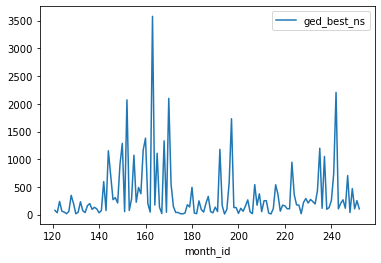

In [225]:
over_time_df.plot.line(y="ged_best_ns", use_index=True);

## Organizing a complicated data munging task

The previous examples were applying aggregation or summary functions. They reduced the data after grouping it.

Sometime we want to split, but the functions we apply to the split do **not** reduce the data, but use the virtual split vectors in particular ways.

One common operation that is relatively complicated is counting spells, particularly since the last outbreak of violence. 

What will will want in this case is to create a new variable, that will count the time since the last non-zero fatalities observation (or the beginning of the series if there has not been one yet).

We can see that this is another split-apply-combine problem.

We will: 

- be careful to sort the df by ascending `month_id` (it already is, but to be sure), groupby preserves order within group
    - We get `sort_index` for free

- create a new variable to track the month of non-zero fatalities, with np.nan (missing code) if zero or missing.
    - see `assign_last_event_date` below

- then `.groupby` `country_id` (could also use `country_name` here)
    - we get `groupby` for free

- For each group, shift the timing so that it lagged one year; also ensure that the entry year is marked as the beginning date (like a previous event)
    - see `shift_last_event_data` below

- fill the non-zero-fatalities month_id forward for each country (group),
    - see `fill_last_event_data_forward` below

- then subtract the current month from the last event that is recorded in the previous month
    - see `assign_time_since_event_or_entry` below


Because this operation is complicated enough, it makes sense to wrap tasks in functions that have names and even docstrings that give hints to our future selves and others what we are doing.

Understanding what `df.assign(last_event_date=np.where(df[event_col_name]>threshold, df.index.to_frame()[date_id_name], false_value))` is supposed to do is difficult

Labeling that with`assign_last_event_date` and a short docstring reduces the chance for errors and makes debugging easier later. 

We do not need functions for sorting or grouping, but here are two functions for each of the other 4 tasks.

I also created a small helper function `calc_entry_date` that is used in `shift_last_event_date`.

In [472]:
def assign_last_event_date(df, event_col_name="ged_best_ns", date_id_name="month_id", false_value=np.nan, threshold=0):
    """calculate date `event_col_name` crossed `threshold`
    Note: assumes MultiIndex
    """
    return df.assign(last_event_date=np.where(df[event_col_name]>threshold, df.index.to_frame()[date_id_name], false_value))
    

def calc_entry_date(grp, date_id_name="month_id"):
    """calc date group first entered data
    Note: assumes grp is sorted by time
    """
    return int(grp.iloc[[0]].index.to_frame()[date_id_name])


def shift_last_event_date(grp, date_id_name="month_id"):
    """shift last_event_date in grp by 1 unit
    Note: missing values are filled the the first available date minus 1 (to match shifting)
    """
    first_date = calc_entry_date(grp, date_id_name=date_id_name)
    return grp.assign(last_event_date = grp.last_event_date.shift(1, fill_value=first_date-1))

def fill_last_event_date_forward(grp):
    """use .fillna(method="ffill") to feed date forward
    Note: downcast keeps values int64s
    """
    return grp.assign(last_event_date = grp.last_event_date.fillna(method="ffill", downcast="infer"))
    

def assign_time_since_event_or_entry(df, date_id_name="month_id"):
    """Subtract the current time from the shifted prev event time
    Note: counter starts at 0
    """
    return df.assign(time_since_event = df.index.to_frame()["month_id"] - df["last_event_date"] - 1)

We used the `.assign` method to create a new column here (or overwrite one). 

How we want to chain these tasks together. 

In this task we want to `.pipe` a DataFrame forward to a function.

After we `groupby` we want to `.apply` our functions for groups

We need to re-groupby after a call if we need to split-apply-combine again

Here is the chain:

In [474]:
subset_df.sort_index(level=["country_id","month_id"])\
    .pipe(assign_last_event_date)\
    .groupby("country_id")\
    .apply(shift_last_event_date)\
    .groupby("country_id")\
    .apply(fill_last_event_date_forward)\
    .pipe(assign_time_since_event_or_entry)

,,ged_best_ns,month,year,country_name,last_event_date,time_since_event
month_id,country_id,,,,,,
109,120,0.0,1,1989,Somalia,108,0
110,120,0.0,2,1989,Somalia,108,1
111,120,0.0,3,1989,Somalia,108,2
112,120,0.0,4,1989,Somalia,108,3
113,120,0.0,5,1989,Somalia,108,4
...,...,...,...,...,...,...,...
248,167,0.0,8,2000,"Congo, DRC",245,2
249,167,63.0,9,2000,"Congo, DRC",245,3
250,167,76.0,10,2000,"Congo, DRC",249,0


If you do not like the line-ending `\` you can wrap the chain in parentheses.

That gives you an introduction to munging with pandas.

Much much more information can be found in the docs [here](https://pandas.pydata.org/docs/index.html)